# Enhancing Facial Video Quality: A Multi Modal Deep Restoration Approach

In [1]:
import torch
import torch.nn as nn
import torchaudio.transforms as T
import torch.nn.functional as F
import librosa
import os
import dlib
import glob
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class ObamaDataset(Dataset):
    def __init__(self, src_img_dir, target_img_dir, transform=None):
        self.src_img_dir = src_img_dir
        self.target_img_dir = target_img_dir
        self.transform = transform

    def __len__(self):
            return len(os.listdir(self.src_img_dir)) 

    def __getitem__(self, idx):
        ids = str(idx)
        if idx<5294:
            file_name_comp = f"obama000_30kbps_h264_frame{idx:04d}.png"
            file_name_orig = f"obama000_frame{idx:04d}.png"
        elif idx<(11388):
            file_name_comp = f"obama001_30kbps_h264_frame{(idx-5294):04d}.png"
            file_name_orig = f"obama001_frame{(idx-5294):04d}.png"
        else:
            file_name_comp = f"obama002_30kbps_h264_frame{(idx-11388):04d}.png"
            file_name_orig = f"obama002_frame{(idx-11388):04d}.png"
        src_img_path = os.path.join(self.src_img_dir, file_name_comp)
        target_img_path = os.path.join(self.target_img_dir, file_name_orig)
        src_image = np.array(Image.open(src_img_path).convert("RGB"))
        target_image = np.array(Image.open(target_img_path).convert("RGB"))
        if self.transform:
                src_image = self.transform(src_image)
#                 src_image = F.interpolate(src_image.unsqueeze(0), size=(720, 1280), mode='bilinear', align_corners=False).squeeze(0)
                target_image = self.transform(target_image)
        return src_image, target_image

### Encoded Frames

In [ ]:
predictor_path =  "/kaggle/input/frames-obama/shape_predictor_68_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
# win = dlib.image_window()

def face_predictor(file):
    img = dlib.load_rgb_image(file)

    # win.clear_overlay()
    # win.set_image(img)

    dets = detector(img, 1)
    image_size=(256, 256)
    image = torch.zeros(3, *image_size).to(DEVICE)
    if len(dets) == 0 : 
        points = []
    for k, d in enumerate(dets):
        shape = predictor(img, d)
#         win.add_overlay(shape)
        points = shape.parts()
        break
    for point in points:
        x, y = point.x, point.y
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            image[:, y, x] = 1
    return image.to(DEVICE)

In [ ]:
hidden_size = 256  
num_layers = 3 

def extract_mfcc(audio_path):
    audio_signal, sample_rate = librosa.load(audio_path, sr=16000)
    n_mfcc = 13 
    n_fft = 400  
    hop_length = 160 
    n_mels = 40  
    window_size = 21 

    mfcc_transform = T.MFCC(
        sample_rate=1,
        n_mfcc=n_mfcc,
        melkwargs={
            'n_fft': n_fft,
            'n_mels': n_mels,
            'hop_length': hop_length
        }
    )
    
    mfccs = mfcc_transform(torch.Tensor(audio_signal).unsqueeze(0)) 
    mfccs = torch.nan_to_num(mfccs, nan=0)
    mfccs = mfccs.transpose(1, 2) 
        
    return mfccs.to(DEVICE)

In [2]:
from torch.utils.data import random_split

src_img_dir = "/kaggle/input/frames-obama/compressed/New folder"
target_img_dir = "/kaggle/input/frames-obama/original/New folder"

dataset = ObamaDataset(src_img_dir, target_img_dir, transform=ToTensor())

train_data, val_data = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(0))

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=10, shuffle=False)

<PIL.Image.Image image mode=RGB size=256x256 at 0x77FED29EE110>


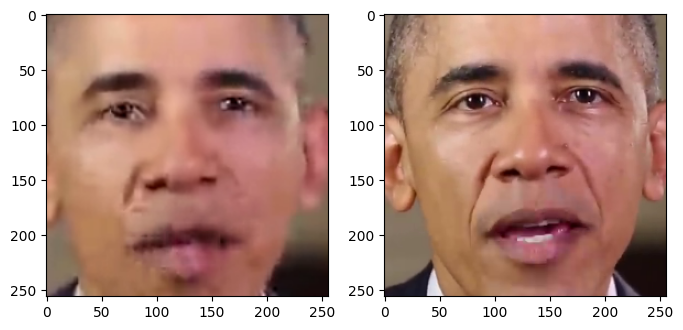

In [4]:
src = train_data[0][0]
tar = train_data[0][1]
figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1,2,1)
to_pil = ToPILImage()
src_img = to_pil(src)
print(src_img)
plt.imshow(src_img)
figure.add_subplot(1,2,2)
tar_img = to_pil(tar)
plt.imshow(tar_img)
plt.show()

In [5]:
src.shape, tar.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

## Models

In [6]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50
IMAGE_HEIGHT = 255
IMAGE_WIDTH = 255

### Audio Branch

In [ ]:
class BiLSTMForAudio(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=True):
        super(BiLSTMForAudio, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True).to(DEVICE)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return out.to(DEVICE)

class UpsamplingResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsamplingResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1).to(DEVICE)
        self.bn1 = nn.BatchNorm2d(out_channels).to(DEVICE)
        self.relu = nn.ReLU(inplace=True).to(DEVICE)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest').to(DEVICE)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1).to(DEVICE)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1).to(DEVICE)
        
        self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1).to(DEVICE)  # 1x1 conv for matching dimensions

    def forward(self, x):
        skip = self.conv_skip(self.upsample(x))

        x = self.upsample(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return (x + skip).to(DEVICE)  

class ASubnet(nn.Module):
    def __init__(self, input_size, initial_feature_dim):
        super(ASubnet, self).__init__()
        self.fc = nn.Linear(input_size, initial_feature_dim*4*4).to(DEVICE)

        self.upres_blocks = nn.Sequential(
            UpsamplingResBlock(initial_feature_dim, initial_feature_dim),
            UpsamplingResBlock(initial_feature_dim, initial_feature_dim // 2),
            UpsamplingResBlock(initial_feature_dim // 2, initial_feature_dim // 2),
            UpsamplingResBlock(initial_feature_dim // 2, initial_feature_dim // 4),
            UpsamplingResBlock(initial_feature_dim // 4, initial_feature_dim // 4),
            UpsamplingResBlock(initial_feature_dim // 4, initial_feature_dim // 4),
        ).to(DEVICE)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 4, 4)
        x = self.upres_blocks(x)
        return x.to(DEVICE)

#### Video Branch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return x
    
class Convolution(nn.Module):
    def __init__(self, inChannel, outChannel, kernel_size = 3, padding=1, stride = 1, upsampling=False, downsampling=False, sampling_factor=2):
        super(Convolution, self).__init__()
        self.upsampling = upsampling
        self.downsampling = downsampling
        self.conv = nn.Conv2d(inChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=stride)
        self.upsample = nn.Upsample(scale_factor=sampling_factor, mode='nearest')
        self.downsample = nn.Conv2d(outChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=sampling_factor)
        self.batchnorm = nn.BatchNorm2d(outChannel)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        if(self.upsampling):
            x = self.upsample(x)
        x = self.relu(self.batchnorm(self.conv(x)))
        if(self.downsampling):
            x = self.downsample(x)
        return x
    
class VSubnet(nn.Module):
    def __init__(self):
        super(VSubnet, self).__init__()
        self.initial_layers = nn.Sequential(
            Convolution(3, 64),
            Convolution(64, 128, downsampling=True),
            Convolution(128, 256, downsampling=True),
        )
        self.res_blocks = nn.Sequential(
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
        )
        self.final_layers = nn.Sequential(
            Convolution(256, 128, upsampling=True),
            Convolution(128, 64, upsampling=True),
        )

    def forward(self, x):
        x = self.initial_layers(x)
        x = self.res_blocks(x)
        x = self.final_layers(x)
        return x

#### landmark branch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Convolution(nn.Module):
    def __init__(self, inChannel, outChannel, kernel_size = 3, padding=1, stride = 1, upsampling=False, downsampling=False, sampling_factor=2):
        super(Convolution, self).__init__()
        self.upsampling = upsampling
        self.downsampling = downsampling
        self.conv = nn.Conv2d(inChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=stride)
        self.upsample = nn.Upsample(scale_factor=sampling_factor, mode='nearest')
        self.downsample = nn.Conv2d(outChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=sampling_factor)
        self.batchnorm = nn.BatchNorm2d(outChannel)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        if(self.upsampling):
            x = self.upsample(x)
        x = self.relu(self.batchnorm(self.conv(x)))
        if(self.downsampling):
            x = self.downsample(x)
        return x
        
class LSubnet(nn.Module):
    def __init__(self):
        super(LSubnet, self).__init__()
        self.layers = nn.Sequential(
            Convolution(3, 64),
            Convolution(64, 128, downsampling=True),
            Convolution(128, 256, downsampling=True),
            Convolution(256, 256, downsampling=True),
            Convolution(256, 256, downsampling=True),
            Convolution(256, 256, upsampling=True),
            Convolution(256, 256, upsampling=True),
            Convolution(256, 128, upsampling=True),
            Convolution(128, 64, upsampling=True),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class SpatialAttentionFusion(nn.Module):
    def __init__(self):
        super(SpatialAttentionFusion, self).__init__()
        self.speech_conv = nn.Conv2d(64 * 2, 64, kernel_size=7, padding=3).to(DEVICE)
        self.landmark_conv = nn.Conv2d(64 * 2, 64, kernel_size=7, padding=3).to(DEVICE)
        self.fusion_conv = nn.Conv2d(64 * 3, 64, kernel_size=1).to(DEVICE)
        self.sigmoid = nn.Sigmoid().to(DEVICE)

    def forward(self, speech_features, video_features, landmark_features):
        speech_video = torch.cat([speech_features, video_features], dim=1)
        landmark_video = torch.cat([landmark_features, video_features], dim=1)
        speech_map = self.sigmoid(self.speech_conv(speech_video))
        landmark_map = self.sigmoid(self.landmark_conv(landmark_video))
        landmark_map = landmark_map * landmark_features
        speech_map = speech_map * speech_features

        fused_features = torch.cat([speech_map, video_features, landmark_map], dim=1)
        fused_features = self.fusion_conv(fused_features)
        return fused_features.to(DEVICE)

## Unet

In [7]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=3,
            kernel_size=1
        )

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)   
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        tanh = nn.Tanh()
        x = tanh(x)
        # print(x.shape)
        return x.to(DEVICE)

## Training

In [8]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter += 1
        image, target = data[0].to(DEVICE),data[1].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs = outputs.squeeze(1)
        target = target.squeeze(1)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image, target = data[0].to(DEVICE),data[1].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            target = target.squeeze(1)
            loss = criterion(outputs,target)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

2024-03-06 22:15:44.679452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 22:15:44.679573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 22:15:44.953044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1 of 50
-------------Training---------------


1391it [13:00,  1.78it/s]



--------Validating---------



348it [02:17,  2.53it/s]


Train Loss: 0.0776
Val Loss: 0.0640
Epoch 2 of 50
-------------Training---------------


1391it [13:05,  1.77it/s]



--------Validating---------



348it [01:40,  3.48it/s]


Train Loss: 0.0631
Val Loss: 0.0595
Epoch 3 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:40,  3.46it/s]


Train Loss: 0.0590
Val Loss: 0.0560
Epoch 4 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:38,  3.53it/s]


Train Loss: 0.0559
Val Loss: 0.0559
Epoch 5 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:39,  3.51it/s]


Train Loss: 0.0538
Val Loss: 0.0531
Epoch 6 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:38,  3.54it/s]


Train Loss: 0.0512
Val Loss: 0.0502
Epoch 7 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:37,  3.57it/s]


Train Loss: 0.0496
Val Loss: 0.0503
Epoch 8 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:34,  3.69it/s]


Train Loss: 0.0477
Val Loss: 0.0481
Epoch 9 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:37,  3.56it/s]


Train Loss: 0.0457
Val Loss: 0.0458
Epoch 10 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:44,  3.34it/s]


Train Loss: 0.0440
Val Loss: 0.0451
Epoch 11 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:44,  3.32it/s]


Train Loss: 0.0426
Val Loss: 0.0435
Epoch 12 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:47,  3.24it/s]


Train Loss: 0.0408
Val Loss: 0.0428
Epoch 13 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:45,  3.29it/s]


Train Loss: 0.0394
Val Loss: 0.0415
Epoch 14 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:43,  3.35it/s]


Train Loss: 0.0381
Val Loss: 0.0420
Epoch 15 of 50
-------------Training---------------


1391it [13:09,  1.76it/s]



--------Validating---------



348it [01:48,  3.21it/s]


Train Loss: 0.0376
Val Loss: 0.0405
Epoch 16 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:45,  3.31it/s]


Train Loss: 0.0358
Val Loss: 0.0395
Epoch 17 of 50
-------------Training---------------


1391it [13:09,  1.76it/s]



--------Validating---------



348it [01:43,  3.35it/s]


Train Loss: 0.0345
Val Loss: 0.0397
Epoch 18 of 50
-------------Training---------------


1391it [13:09,  1.76it/s]



--------Validating---------



348it [01:45,  3.31it/s]


Train Loss: 0.0334
Val Loss: 0.0382
Epoch 19 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:43,  3.37it/s]


Train Loss: 0.0324
Val Loss: 0.0380
Epoch 20 of 50
-------------Training---------------


1391it [13:09,  1.76it/s]



--------Validating---------



348it [01:42,  3.38it/s]


Train Loss: 0.0317
Val Loss: 0.0375
Epoch 21 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:44,  3.33it/s]


Train Loss: 0.0306
Val Loss: 0.0366
Epoch 22 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:35,  3.64it/s]


Train Loss: 0.0298
Val Loss: 0.0372
Epoch 23 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:42,  3.40it/s]


Train Loss: 0.0289
Val Loss: 0.0366
Epoch 24 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:41,  3.41it/s]


Train Loss: 0.0281
Val Loss: 0.0356
Epoch 25 of 50
-------------Training---------------


1391it [13:09,  1.76it/s]



--------Validating---------



348it [01:43,  3.35it/s]


Train Loss: 0.0275
Val Loss: 0.0365
Epoch 26 of 50
-------------Training---------------


1391it [13:09,  1.76it/s]



--------Validating---------



348it [01:44,  3.32it/s]


Train Loss: 0.0267
Val Loss: 0.0355
Epoch 27 of 50
-------------Training---------------


1391it [13:09,  1.76it/s]



--------Validating---------



348it [01:47,  3.25it/s]


Train Loss: 0.0264
Val Loss: 0.0348
Epoch 28 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:48,  3.19it/s]


Train Loss: 0.0254
Val Loss: 0.0347
Epoch 29 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:45,  3.30it/s]


Train Loss: 0.0250
Val Loss: 0.0342
Epoch 30 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:45,  3.29it/s]


Train Loss: 0.0246
Val Loss: 0.0332
Epoch 31 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:45,  3.31it/s]


Train Loss: 0.0239
Val Loss: 0.0330
Epoch 32 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:45,  3.30it/s]


Train Loss: 0.0233
Val Loss: 0.0334
Epoch 33 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:46,  3.28it/s]


Train Loss: 0.0229
Val Loss: 0.0326
Epoch 34 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:45,  3.29it/s]


Train Loss: 0.0224
Val Loss: 0.0337
Epoch 35 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:45,  3.31it/s]


Train Loss: 0.0220
Val Loss: 0.0324
Epoch 36 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:45,  3.30it/s]


Train Loss: 0.0216
Val Loss: 0.0323
Epoch 37 of 50
-------------Training---------------


1391it [13:08,  1.77it/s]



--------Validating---------



348it [01:47,  3.25it/s]


Train Loss: 0.0220
Val Loss: 0.0315
Epoch 38 of 50
-------------Training---------------


1391it [13:08,  1.77it/s]



--------Validating---------



348it [01:42,  3.39it/s]


Train Loss: 0.0207
Val Loss: 0.0350
Epoch 39 of 50
-------------Training---------------


1391it [13:07,  1.77it/s]



--------Validating---------



348it [01:44,  3.33it/s]


Train Loss: 0.0206
Val Loss: 0.0319
Epoch 40 of 50
-------------Training---------------


1391it [13:08,  1.76it/s]



--------Validating---------



348it [01:46,  3.27it/s]


Train Loss: 0.0202
Val Loss: 0.0319


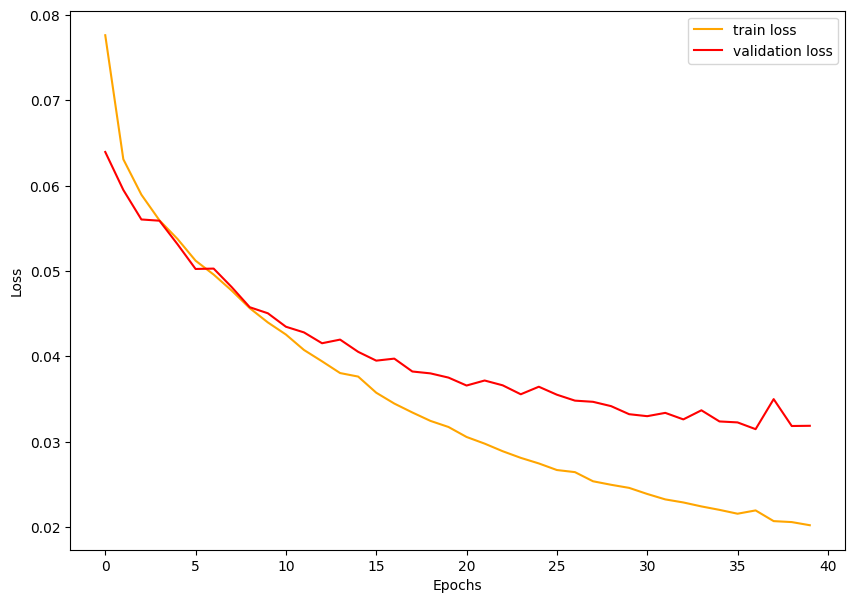


---------DONE TRAINING----------



In [10]:
from tqdm import tqdm
import torch.optim as optim
from keras.callbacks import EarlyStopping

train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.L1Loss()
early_stopper = EarlyStopper(patience=3)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, test_dataloader, val_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, "./model.pth") 
    if early_stopper.early_stop(val_epoch_loss):             
        break
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f"../input/loss.png")
plt.show()

print("\n---------DONE TRAINING----------\n")

### Evaluation

In [11]:
model = UNet()
checkpoint = torch.load('Code\Trained model\mdvd-model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)

In [12]:
model.eval()

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_s

In [13]:
val,target = val_data[0][0].to(DEVICE), val_data[0][1].to(DEVICE)

In [14]:
output = model(val.unsqueeze(0))
pred = output = output.squeeze(0)
output = to_pil(output)

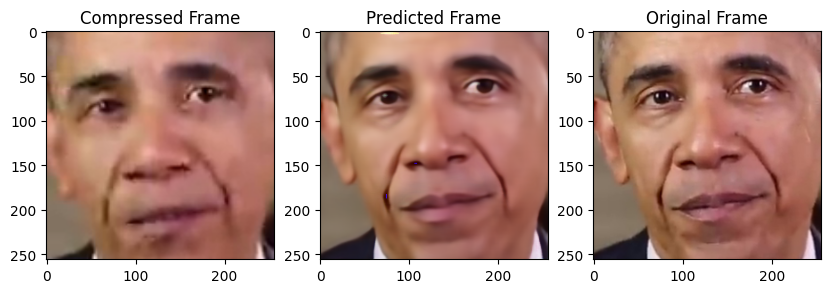

In [ ]:
figure = plt.figure(figsize=(10, 10))
x1 = figure.add_subplot(1,3,1)
plt.imshow(to_pil(val))
x2 = figure.add_subplot(1,3,2)
plt.imshow(to_pil(pred))
x3 = figure.add_subplot(1,3,3)
plt.imshow(to_pil(target))
x1.title.set_text("Compressed Frame")
x2.title.set_text("Predicted Frame")
x3.title.set_text("Original Frame")
plt.show()

In [ ]:
import numpy as np
from skimage import metrics
from skimage import io

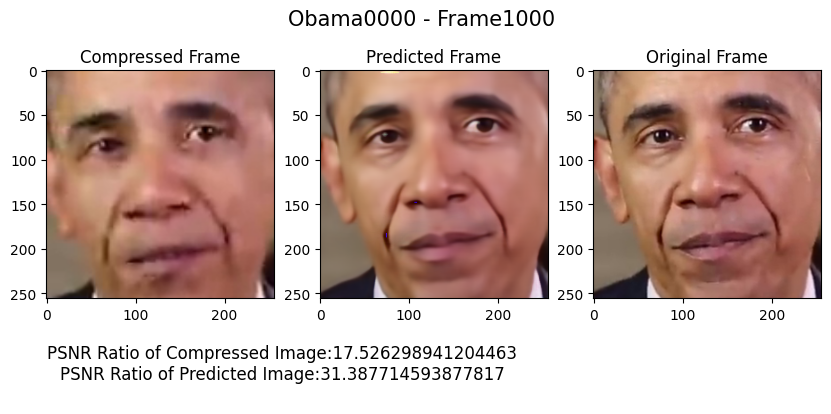

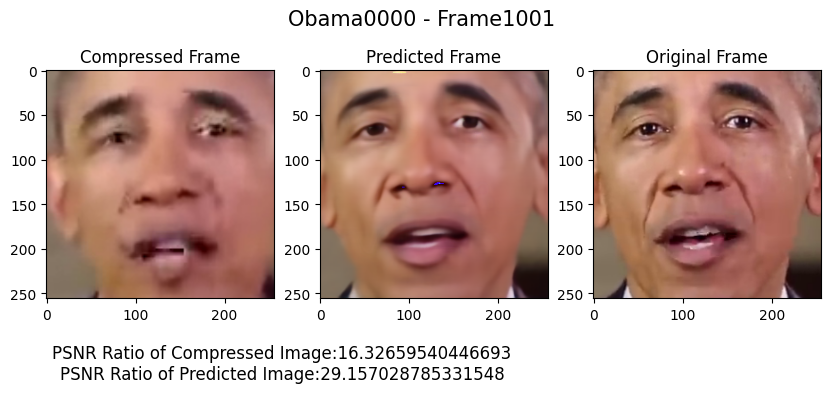

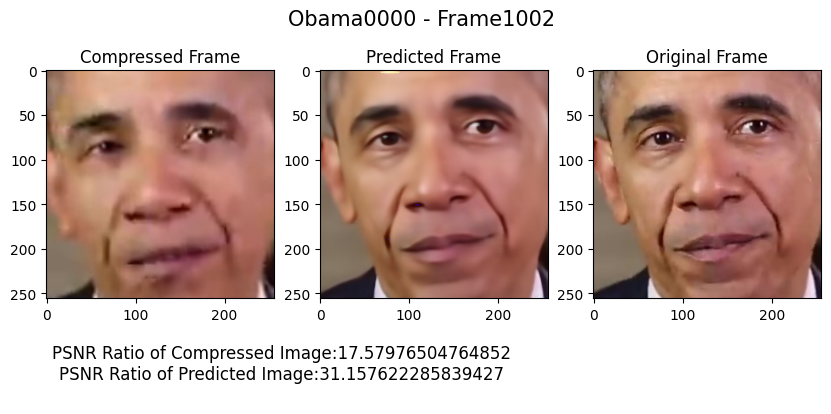

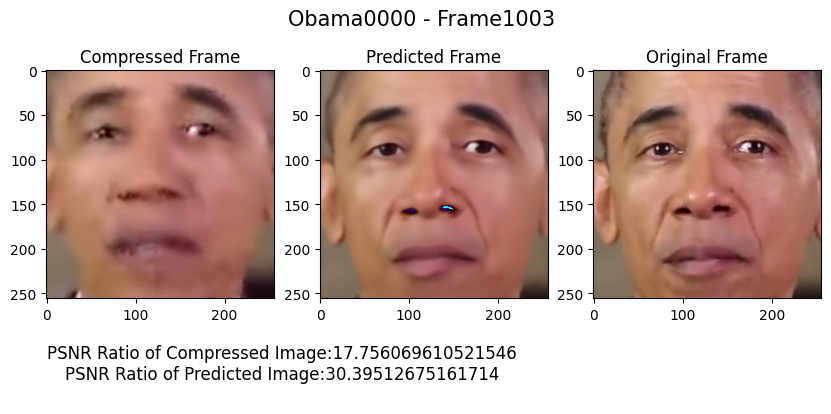

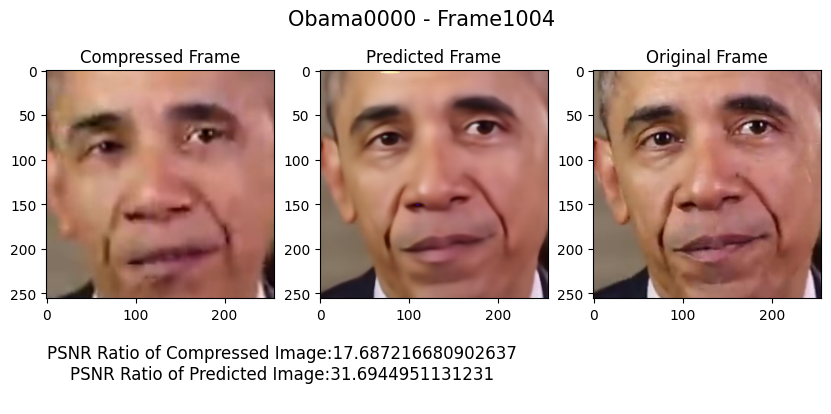

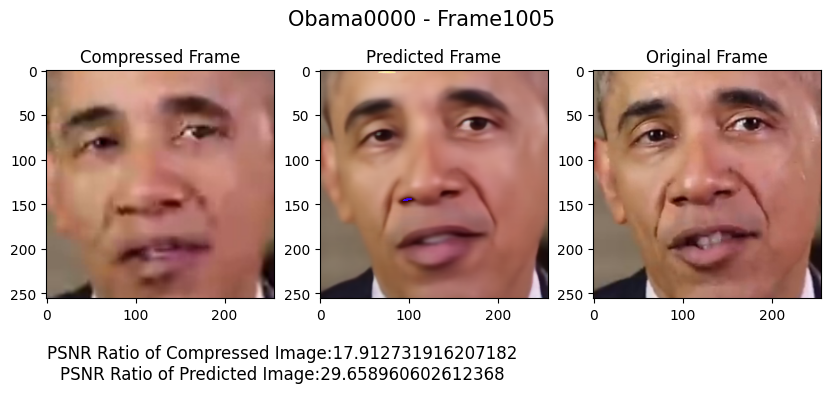

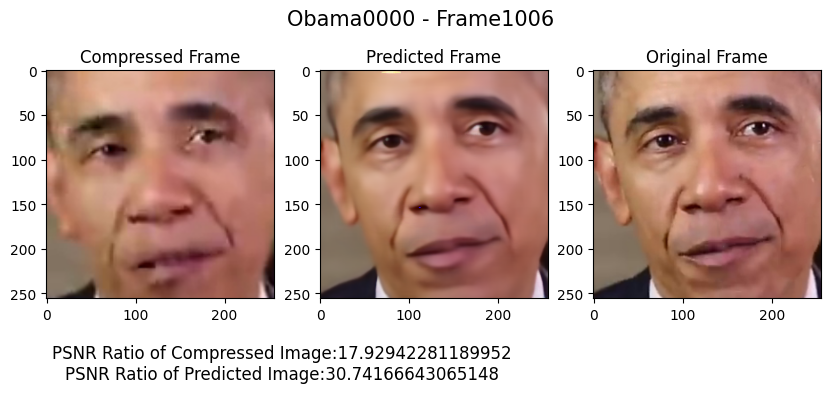

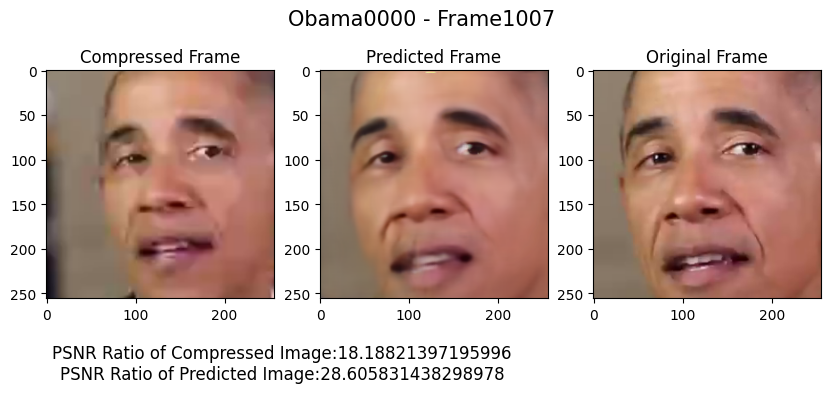

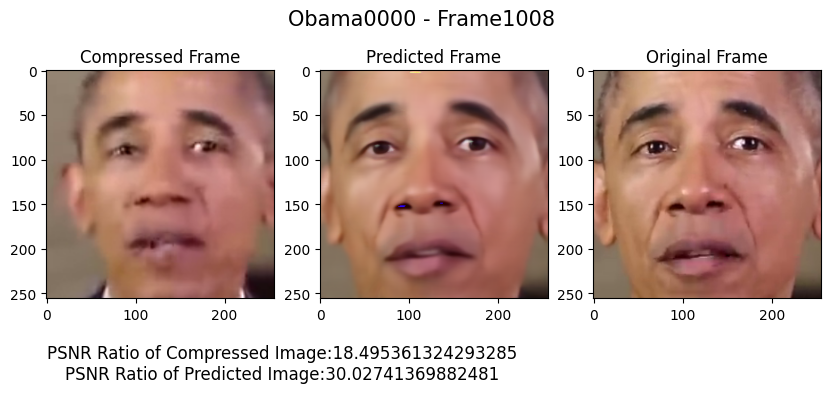

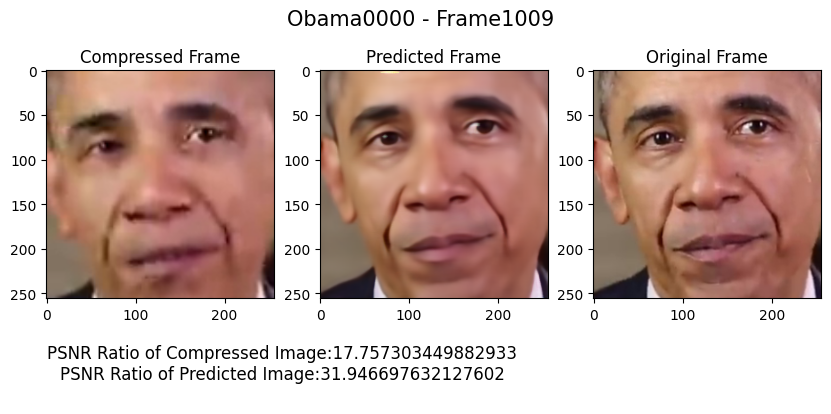

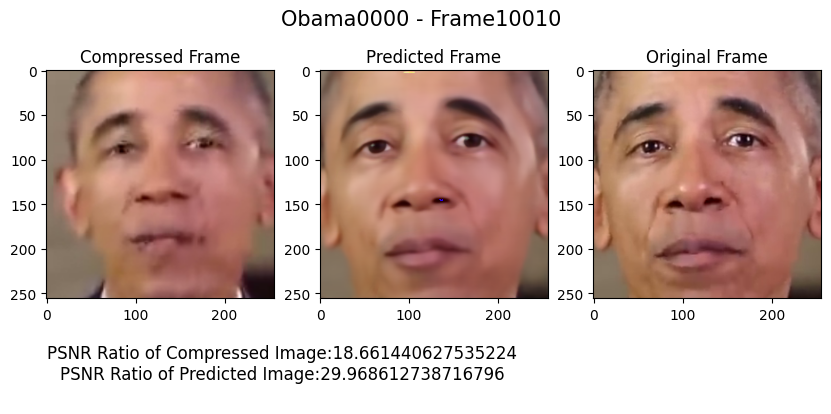

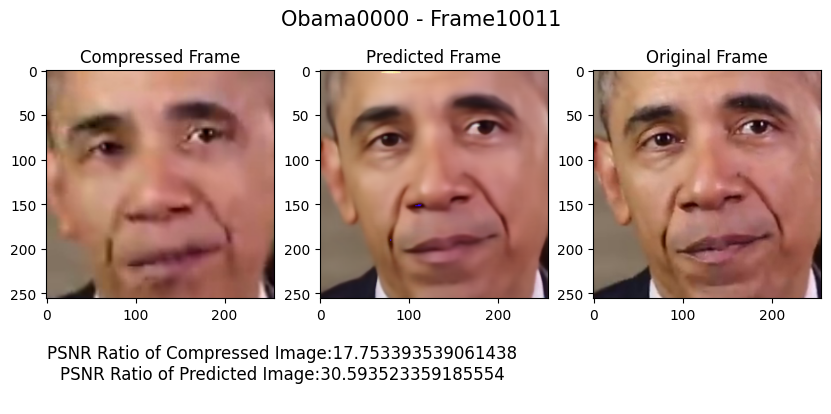

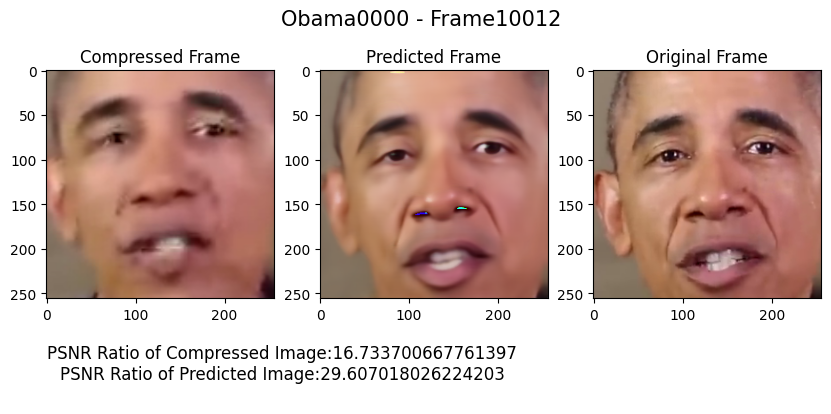

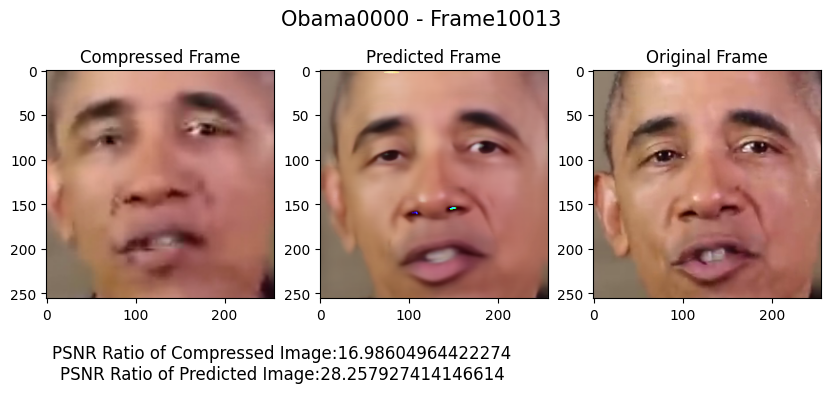

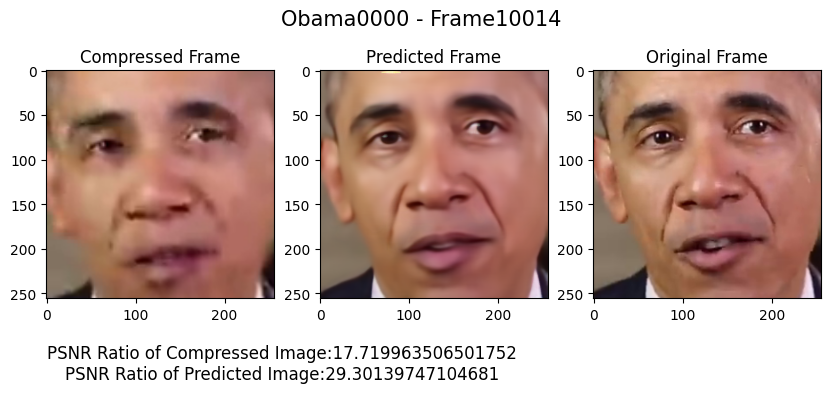

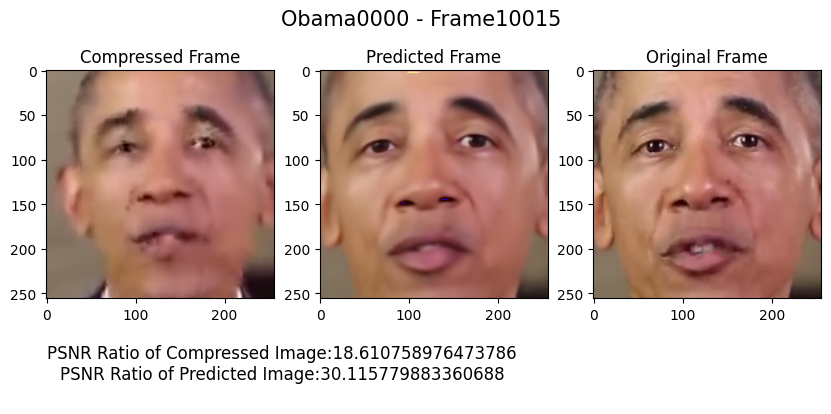

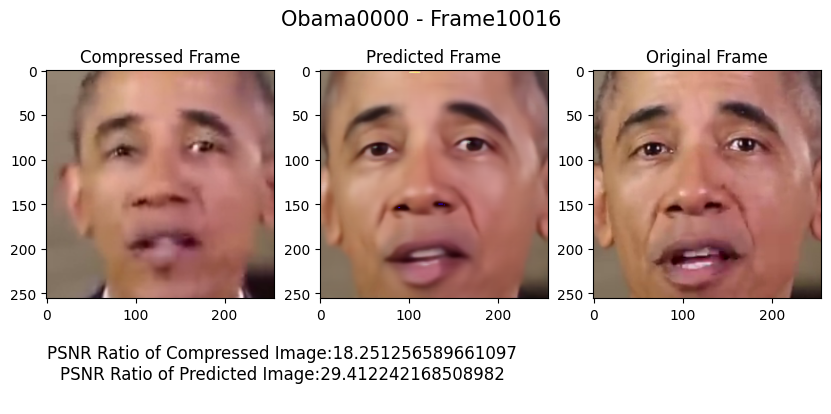

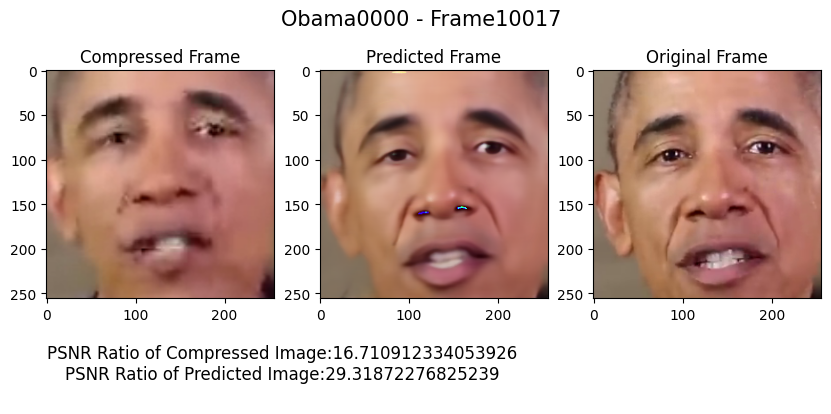

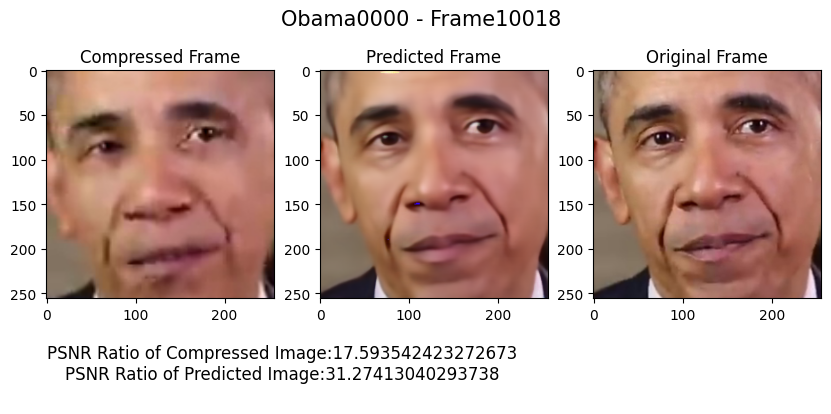

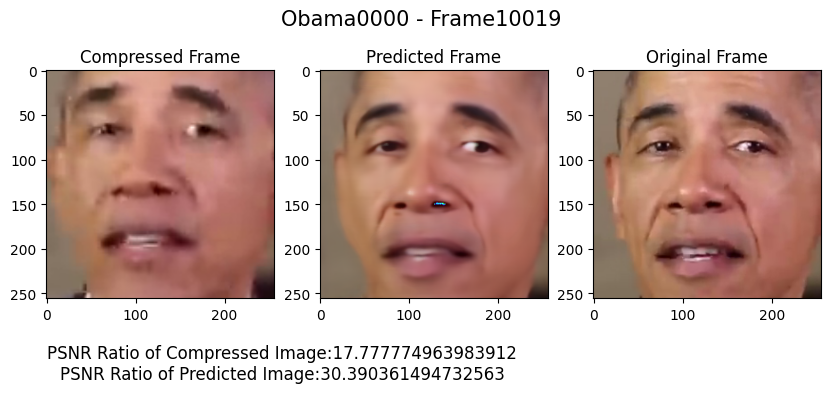

In [ ]:
for i in range(20):
    val,target = val_data[i][0].to(DEVICE), val_data[i][1].to(DEVICE)
    output = model(val.unsqueeze(0))
    pred = output = output.squeeze(0)
    output = to_pil(output)
    val = val.detach().cpu()
    pred = pred.detach().cpu()
    target = target.detach().cpu()
    
    ref_image = target.numpy()
    pred_image = pred.numpy()
    comp_image = val.numpy()    

    ref_image = ref_image.astype(np.float32)
    pred_image = pred_image.astype(np.float32)
    comp_image = comp_image.astype(np.float32)


    # Compute PSNR
    psnr_value_comp = metrics.peak_signal_noise_ratio(ref_image, comp_image)
    psnr_value_pred = metrics.peak_signal_noise_ratio(ref_image, pred_image)
    
    value = f"PSNR Ratio of Compressed Image:{psnr_value_comp}\nPSNR Ratio of Predicted Image:{psnr_value_pred}\n"

    figure = plt.figure(figsize=(10, 10))
    figure.suptitle(f"Obama0000 - Frame100{i}", fontsize=15)
    x1 = figure.add_subplot(1,3,1)
    plt.imshow(to_pil(val))
    x2 = figure.add_subplot(1,3,2)
    plt.imshow(to_pil(pred))
    x3 = figure.add_subplot(1,3,3)
    plt.imshow(to_pil(target))
    x1.title.set_text("Compressed Frame")
    x2.title.set_text("Predicted Frame")
    x3.title.set_text("Original Frame")
    plt.text(-350, 370, value, fontsize=12, ha='center')
    plt.subplots_adjust(top=1.5)
    plt.show()
    